In [1]:
from k1lib.imports import *

In [2]:
class SkipBlock(nn.Module):
    def __init__(self, hiddenDim=10):
        super().__init__()
        def gen(): return nn.Linear(hiddenDim, hiddenDim), nn.LeakyReLU()
        self.seq = nn.Sequential(*gen(), *gen(), *gen())
    def forward(self, x):
        return self.seq(x) + x

In [3]:
class Network(nn.Module):
    def __init__(self, hiddenDim=10, blocks=2, block=SkipBlock):
        super().__init__()
        layers = []
        layers += [nn.Linear(1, hiddenDim), nn.LeakyReLU()]
        for i in range(blocks): layers += [block(hiddenDim)]
        layers += [nn.Linear(hiddenDim, 1)]
        self.bulk = nn.Sequential(*layers)
    def forward(self, x):
        return self.bulk(x)

In [4]:
def newL(bs=64, optF=None, *args, **kwargs):
    optF = lambda p: optim.Adam(p, lr=5e-3)
    l = k1lib.Learner()
    l.model = Network(*args, **kwargs)
    l.data = k1lib.data.Data.fromDataset(k1lib.data.FunctionDataset.exp, bs)
    l.opt = optF(l.model.parameters())
    l.lossF = lambda x, y: ((x.squeeze() - y)**2).mean()
    l.cbs.withModifyBatch(lambda x, y: (x[:, None], y))
    l.cbs.withDType(torch.float32);
    l.css = """
SkipBlock #0: HookParam
SkipBlock: HookModule
"""
    def evaluate(self):
        xbs, ybs, ys = self.record(1, 3)
        xbs = torch.vstack(xbs).squeeze()
        ybs = torch.vstack([yb[:, None] for yb in ybs]).squeeze()
        ys = torch.vstack(ys).squeeze()
        plt.plot(xbs, ys.detach(), ".")
    l.evaluate = partial(evaluate, l)
    l.cbs.withCancelOnLowLoss(1, epochMode=True)
    return l

In [72]:
l = newL(blocks=2)
l.run(10); l.save("2.pth")

Progress:  30%, epoch:  2/10, batch: 155/157, elapsed:   1.46s  Run cancelled: Low loss 1 achieved!.
Saved to autosave-2.pth
Saved to 2.pth


In [47]:
l = newL(blocks=100)
l.run(10); l.save("100.pth")

Progress: 100%, epoch:  9/10, batch: 156/157, elapsed: 125.08s  Saved to autosave-2.pth
Saved to 100.pth


In [34]:
l = newL(blocks=300)
l.run(10); l.save("300.pth")

Progress:  50%, epoch:  4/10, batch: 151/157, elapsed: 184.13s  Run cancelled: Low loss 1 achieved!.
Saved to autosave-2.pth


## Analysis

### 2 skip blocks, control

In [5]:
l0 = k1lib.Learner.load("2.pth")

Loaded from 2.pth


In [10]:
l0.selector

ModuleSelector:
root: Network                     
    bulk: Sequential                     
        0: Linear                         
        1: LeakyReLU                         
        2: SkipBlock                     HookModule
            seq: Sequential                     
                0: Linear                     HookParam    
                1: LeakyReLU                         
                2: Linear                         
                3: LeakyReLU                         
                4: Linear                         
                5: LeakyReLU                         
        3: SkipBlock                     HookModule
            seq: Sequential                     
                0: Linear                     HookParam    
                1: LeakyReLU                         
                2: Linear                         
                3: LeakyReLU                         
                4: Linear                         
                5: Lea

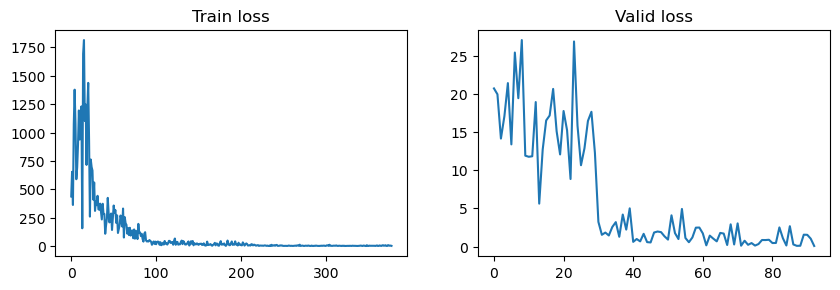

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [74]:
l0.Loss.plot()

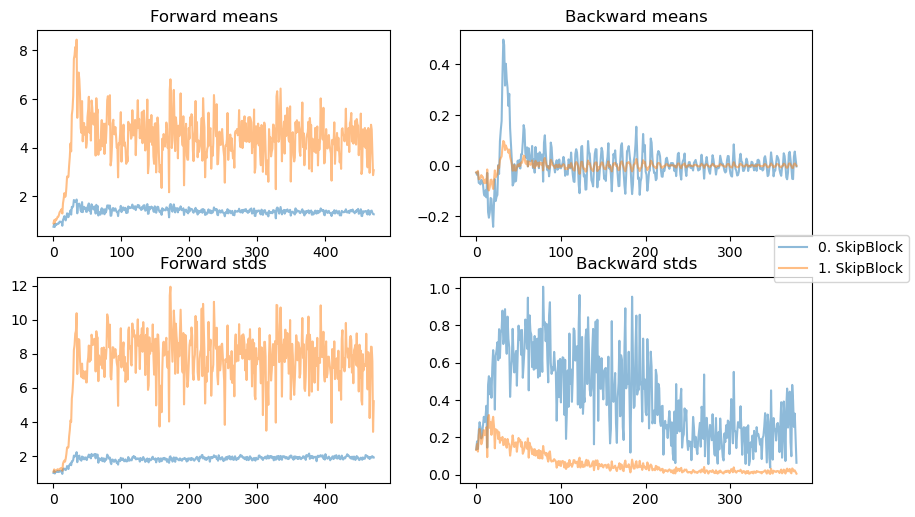

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [85]:
l0.HookModule.plot()

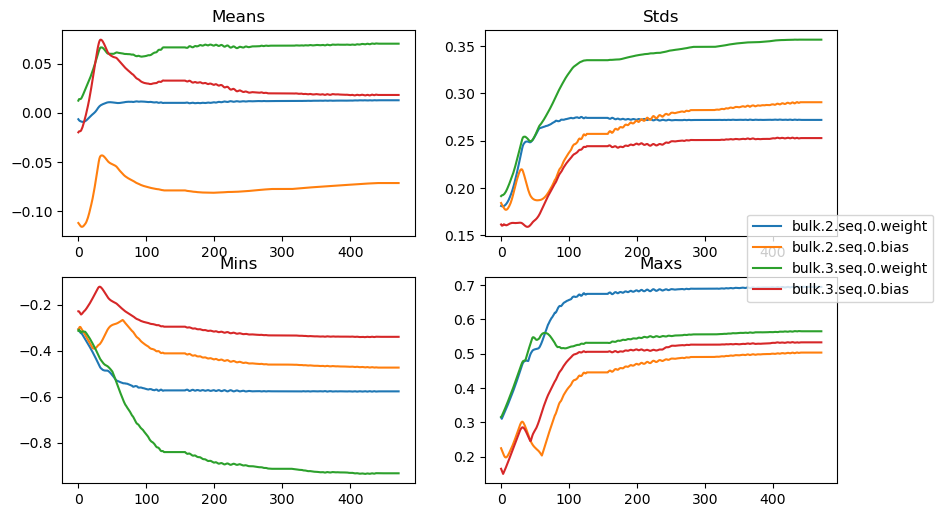

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [87]:
l0.HookParam.plot()


Progress: 100%          8/8 Finished [-3.2, 3.2] range                          

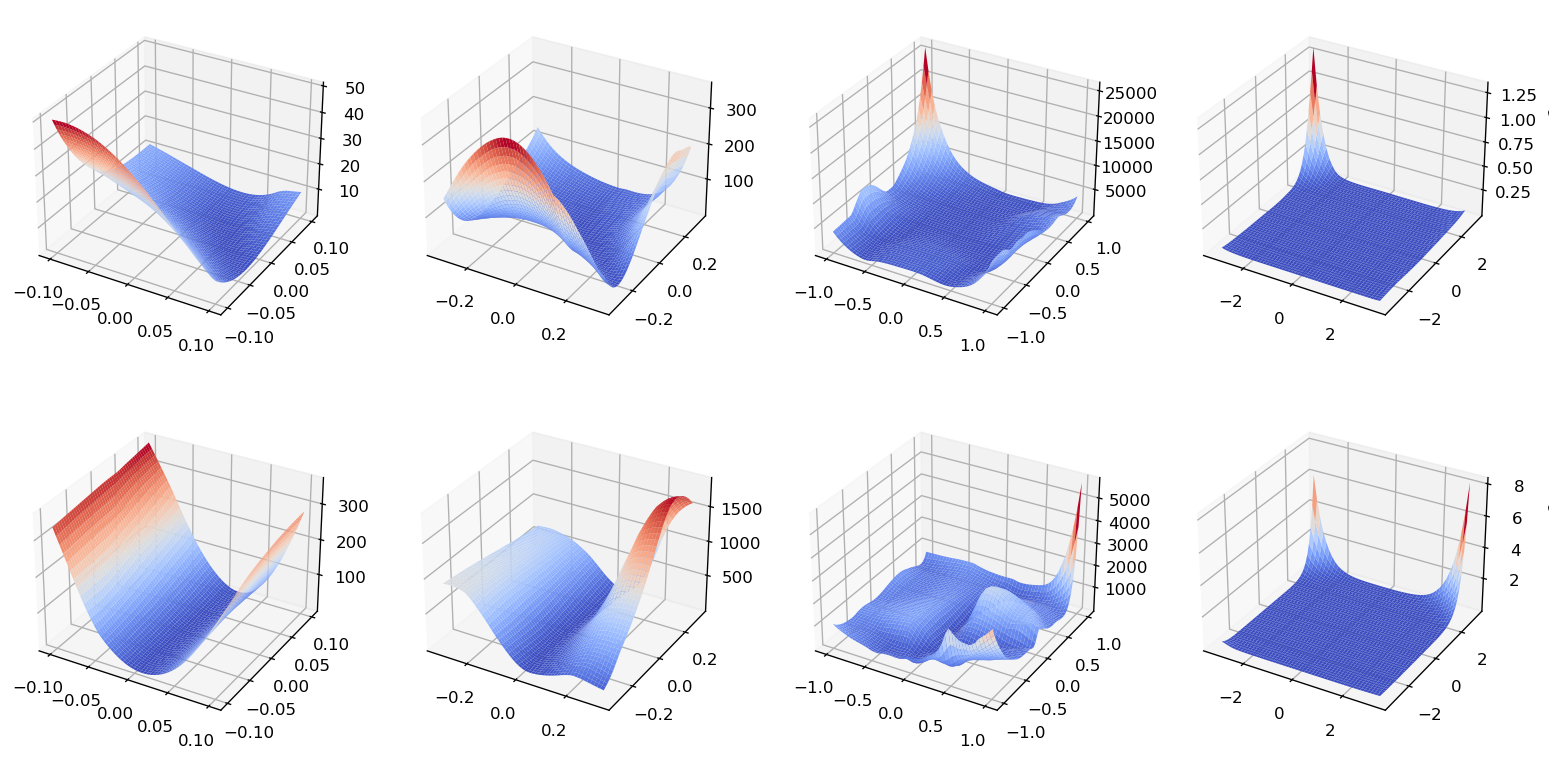

In [89]:
l0.LossLandscape.plot()

Interesting landscape for sure!

### 100 skip blocks

In [7]:
l1 = k1lib.Learner.load("100.pth")

Loaded from 100.pth


It sure drops by a lot right away

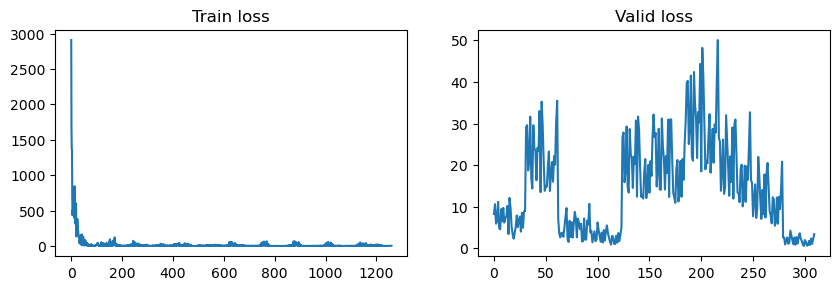

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [8]:
l1.Loss.plot()

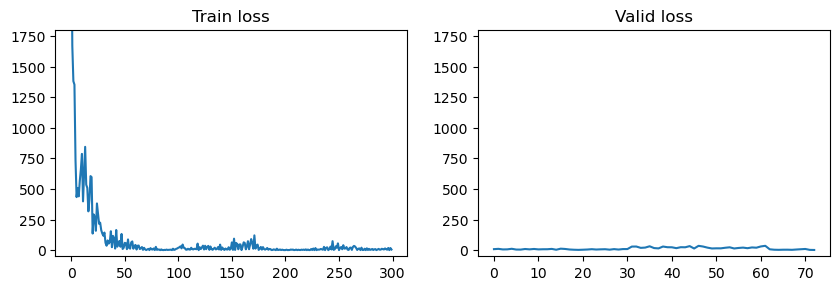

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [84]:
l1.Loss.plot()[:300].ylim(-50, 1800)

Seems like it drops off faster than 2 skip blocks. Hard to tell though. Valid loss is a lot more crazy than 2 skip blocks though. May be, the initialization space is kinda already hard to navigate, so it just has to iron out all the defects before actually demonstrating that it works.

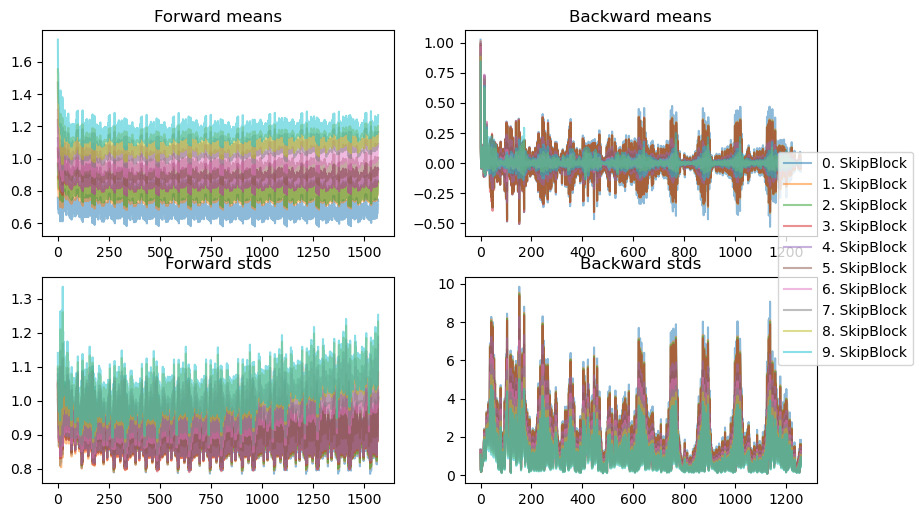

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [92]:
l1.HookModule[:10].plot()

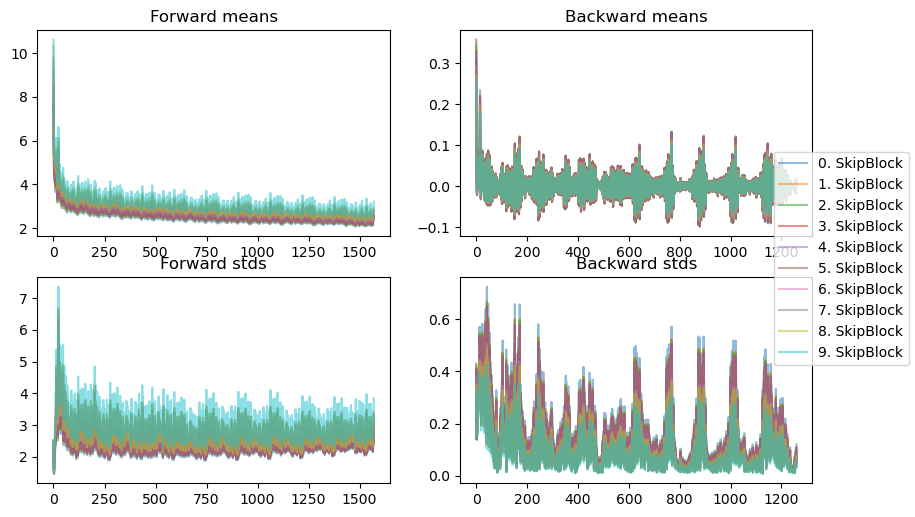

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [101]:
l1.HookModule[45:55].plot()

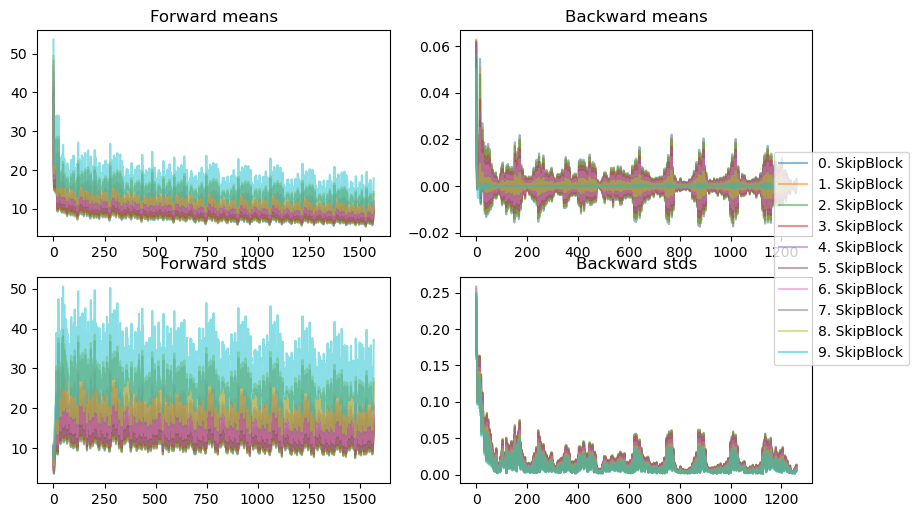

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [94]:
l1.HookModule[-10:].plot()

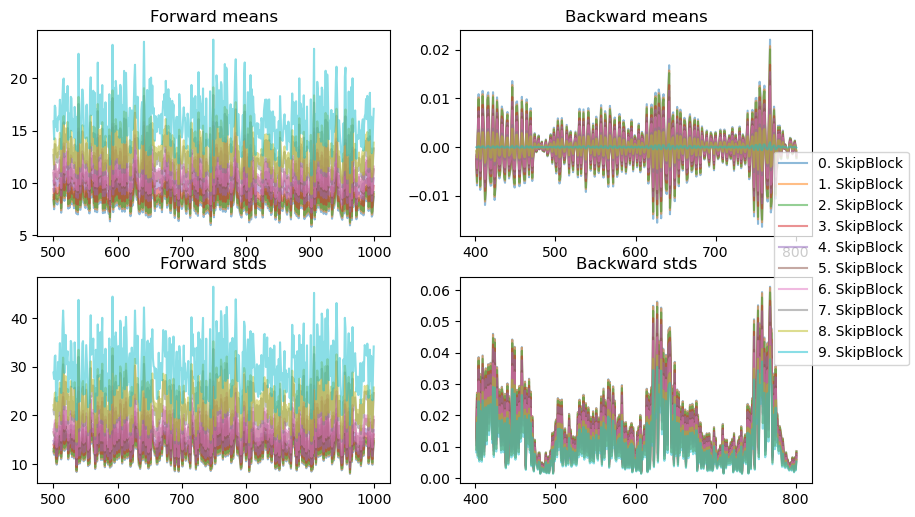

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [97]:
l1.HookModule[-10:].plot()[500:1000]

Relative scales:

| 2 blocks | forward | backward
|-|-|-|
| beginning | 2 | 0.2 |
| end | 5 | 0.02 |

| 100 blocks | forward | backward |
|-|-|-|
| beginning | 1.6 | 0.5 |
| middle | 4 | 0.15 |
| end | 20 | 0.02 |

| 300 blocks | forward | backward |
|-|-|-|
| beginning | 1.2 | 0.2 |
| middle | 10 | 0.06 |
| end | 140 | 0.03 |

So, end of destination always has the biggest scale. And also look at how eerily similar the backward magnitude of all 3 scales are. Forward magnitude is a lot more with deeper networks though, making an explosion sort of imminent.

Also, zomming in, it's clear that the large scale cycle is due to the training batch size. Inside that are higher frequency oscillations, which is due to Adam being a dick and can't deal with a high lr.


Progress: 0%            4/8 Finished [-3.2, 3.2] range                          

/home/kelvin/anaconda3/envs/torch/lib/python3.8/site-packages/k1lib-0.1.3-py3.8.egg/k1lib/_callbacks/lossLandscape.py:27: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(x, y, z, cmap=plt.cm.coolwarm)


Progress: 100%          7/8 Finished [-1, 1] range                  8/8 Finished [-3.2, 3.2] range       

/home/kelvin/anaconda3/envs/torch/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


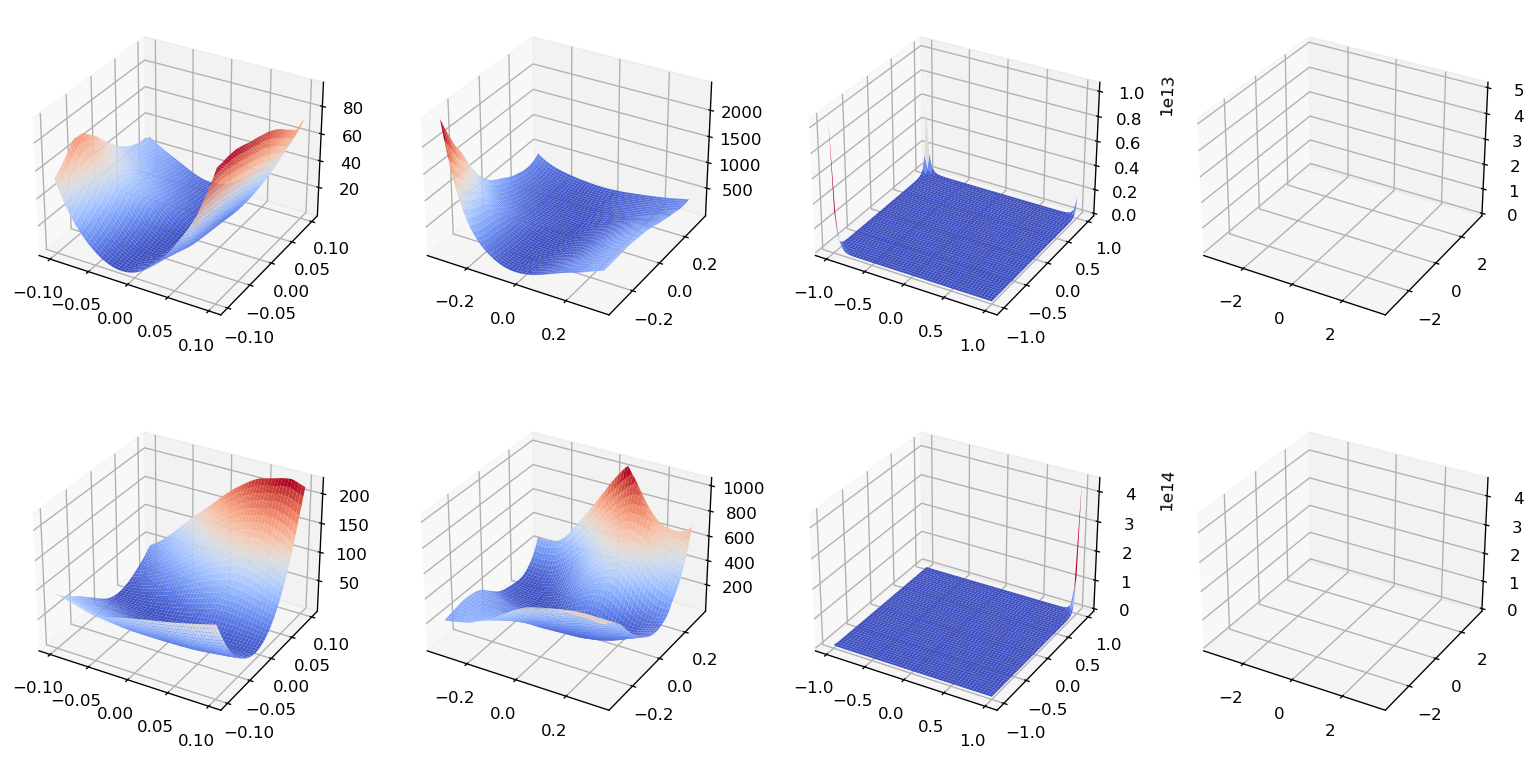

In [105]:
l1.LossLandscape.plot()

### 300 skip blocks

In [12]:
l3 = k1lib.Learner.load("300.pth")

Loaded from 300.pth


In the beginning, it's pretty violent, reaching to 1e8 levels:

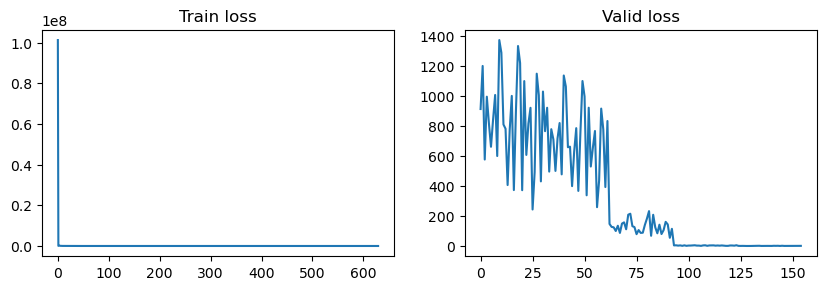

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [102]:
l3.Loss.plot()

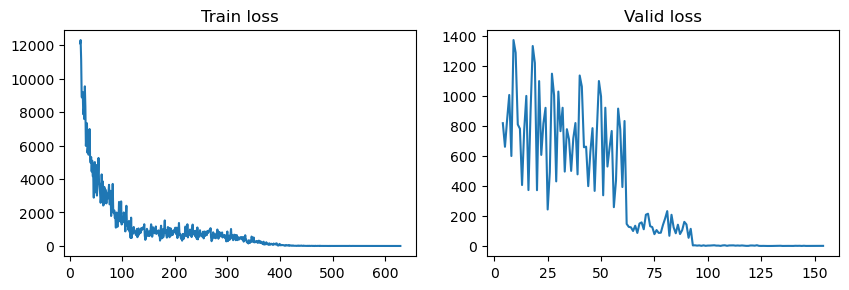

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [104]:
l3.Loss.plot()[20:]

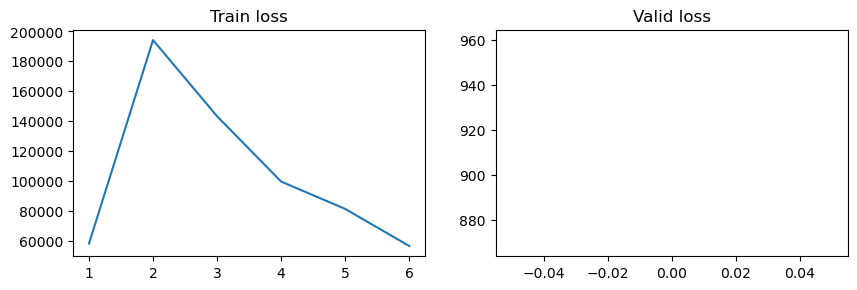

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [69]:
l3.Loss.plot()[1:7]

There's some structure to the decrease though. You can almost see the bouncing around from the debias mechanism inside Adam. First it's 1e8, then drops to 60k, then go to 200k. Only at this moment, where things have sort of settle down from the initial highly chaotic region, and start to decrease reliably. HookModule and HookParam surely has something to say?

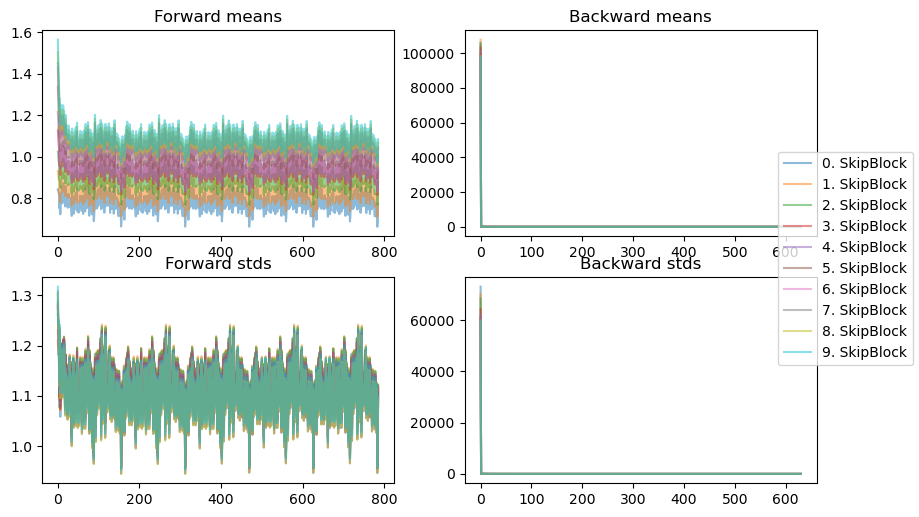

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [147]:
l3.HookModule[:10].plot()

Also pretty crazy. If we zoom in past initial explosion, it's even more interesting though:

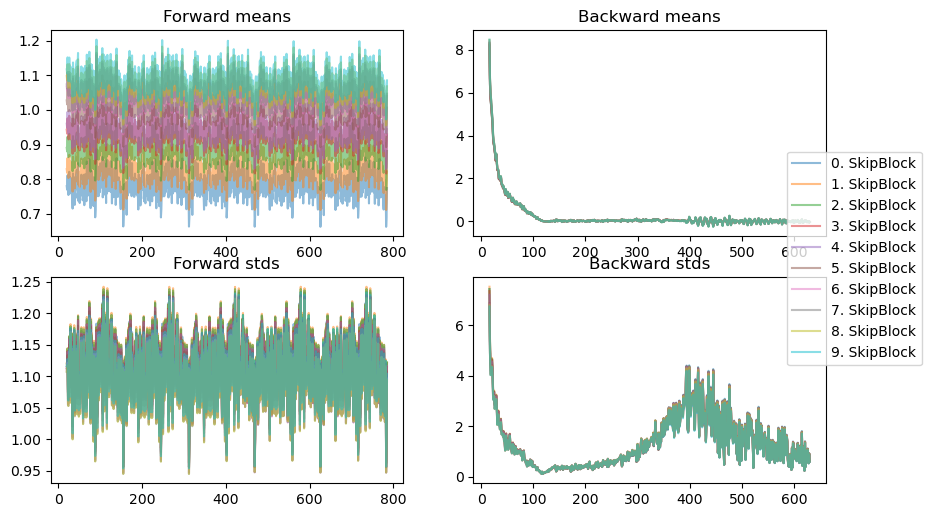

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [116]:
l3.HookModule[:10].plot()[20:]

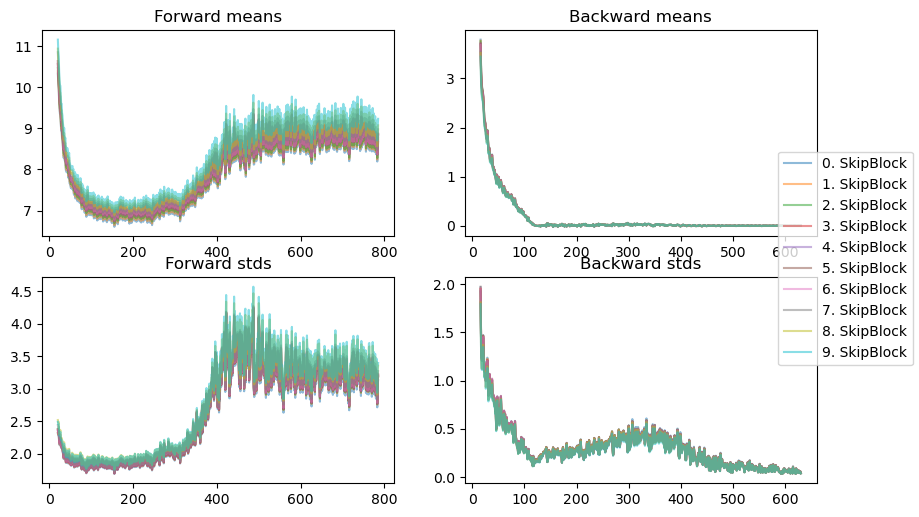

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [153]:
l3.HookModule[145:155].plot()[20:]

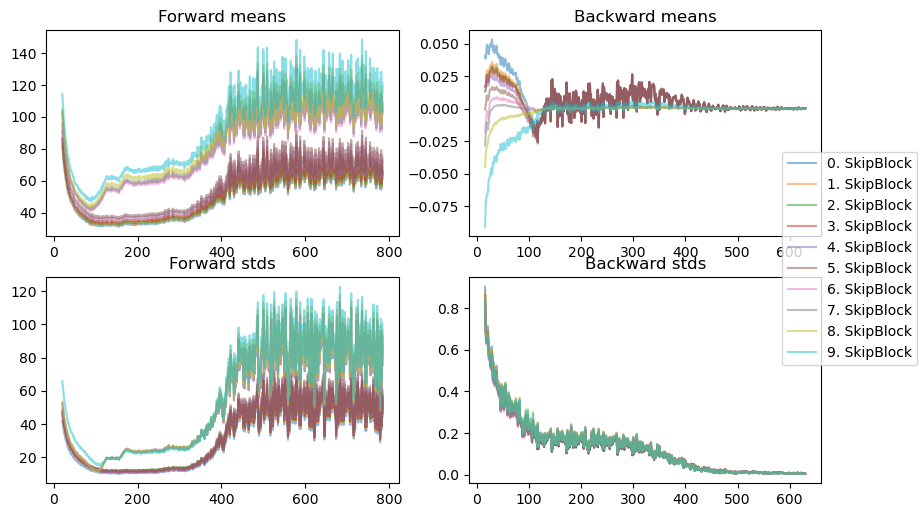

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [154]:
l3.HookModule[-10:].plot()[20:]

Okay this is superrrr interesting. See how backward stds of final layers rises up a lot at 200, bit middle backward stds, the rise up point is at 350, and at the beginning, it's at 400, and is significantly more varied. Also notice how final layers backward stds only go down after around 400 or so. So my guess is, the final layers are trained a lot first, to sort of understand what the domain is. Then the final layers get it, then the middle layers ramp up, and once it understands the domain, first layers then ramp up. Only then does the loss drops off to very low levels. Here's loss again, notice how it flattens after 350:

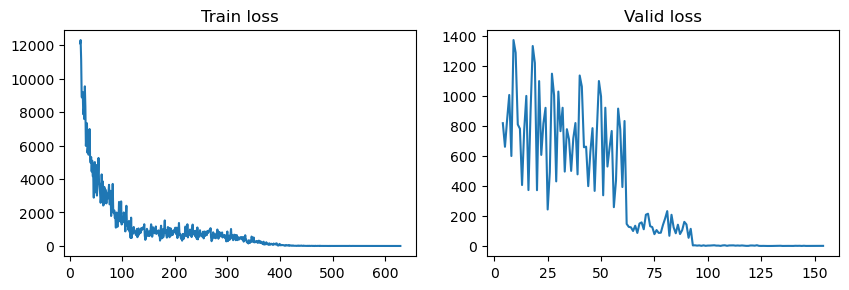

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [156]:
l3.Loss.plot()[20:]

Also, off screen, I also did an experiment with 1000 blocks, and the loss is like 1e29. And notice how beginning backward stds like, peaks so high. May be if you lengthen it a lot more, then that peak explodes, and thus network's loss is at 1e29. So essentially, when the network can't have at least a feel of the domain quick enough, values will diverge and hence 1e29.

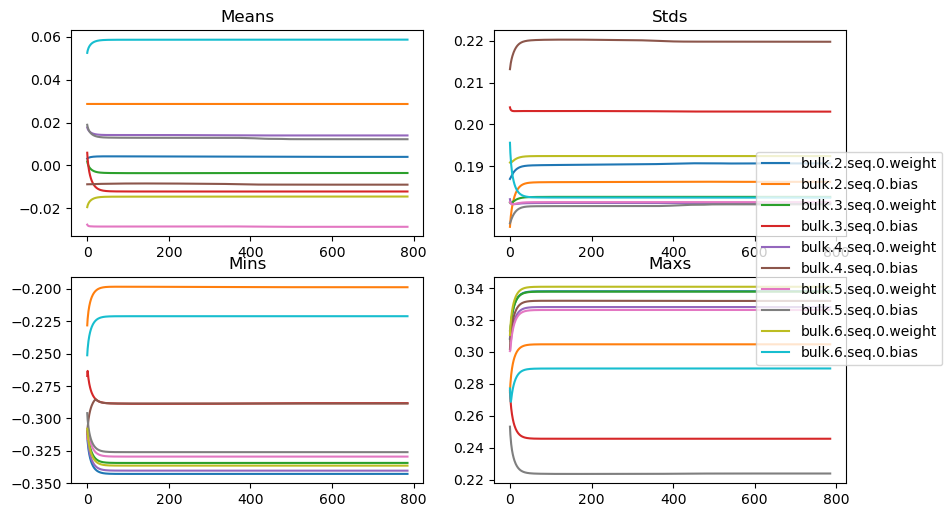

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [181]:
l3.HookParam[:10].plot()

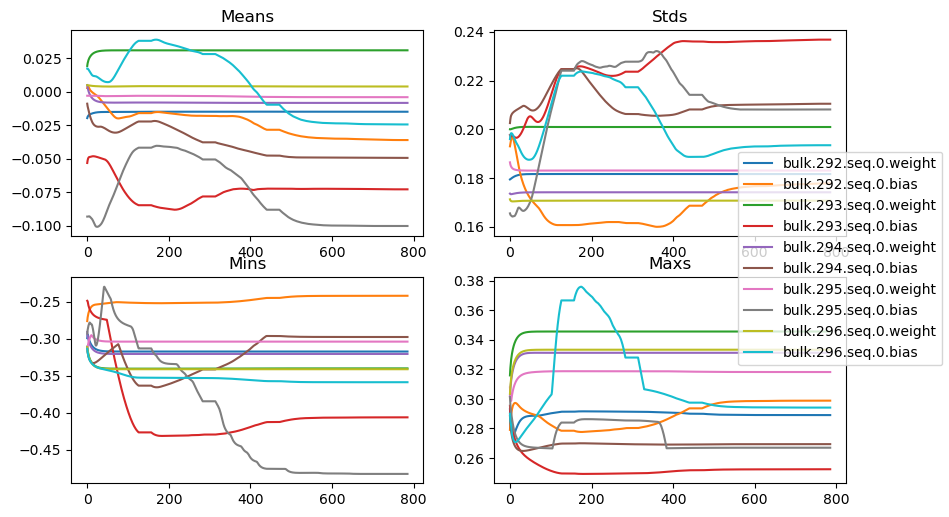

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

In [180]:
l3.HookParam[580:590].plot()

Beginning layers changes rapidly as loss decreases a lot. I sort of think this is unintentional though. For whatever reason, backward signal rises up a whole lot, then the network goes to a space that's sort of random, but still works, I guess. Changes in final layers looks intentional though, so no question about that.

Finally, here's the loss landscape. Not too interesting:


Progress: 100%          8/8 Finished [-3.2, 3.2] range                               3/8 Finished [-1, 1] range       

/home/kelvin/anaconda3/envs/torch/lib/python3.8/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


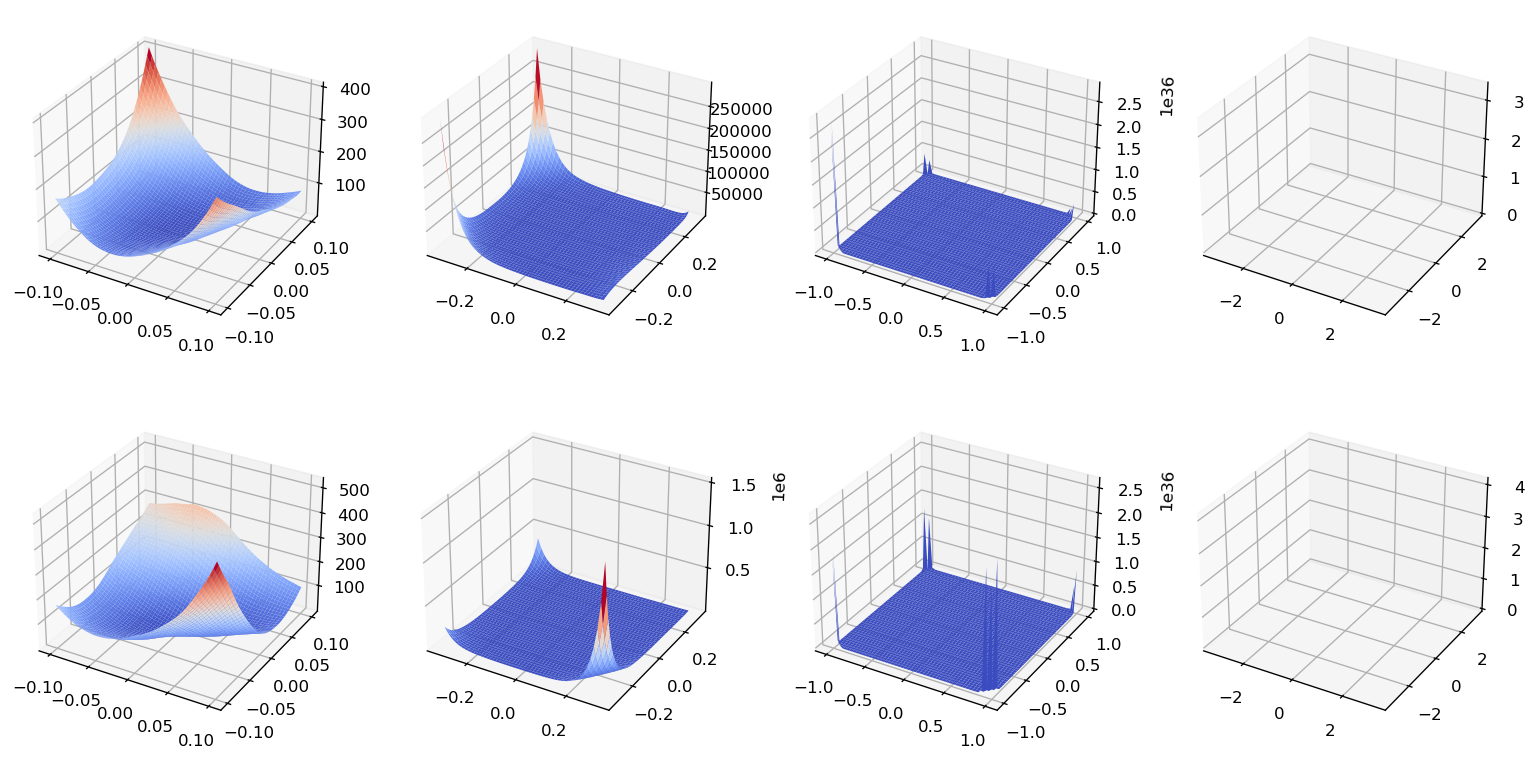

In [108]:
l3.LossLandscape.plot()